# Genomics MRP Demo

Run the genomics example end-to-end with the MRP framework.

- Requirements:
  - Python 3.12+
  - Project installed (`pip install -e .`)
  - For cloud run: `DAYTONA_API_KEY` set in environment (no .env required)
- Outputs: produced under `.mrp/outputs/<job_id>/<timestamp>/` and referenced by `output_dir` in the run artifact.



In [21]:
import os, json, subprocess, shlex
from pathlib import Path

def find_repo_root(start: Path = Path.cwd()) -> Path:
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists():
            return p
    raise RuntimeError("Could not locate repo root (pyproject.toml)")

REPO = find_repo_root()
JOB = REPO / "examples/jobs/cloud_genomics.yaml"
BACKEND = "cloud_sandbox"  # or "local"

print(f"Repo: {REPO}\nJob: {JOB}\nBackend: {BACKEND}")

Repo: /Users/hamidbagheri/GitHub/a10i/mrp
Job: /Users/hamidbagheri/GitHub/a10i/mrp/examples/jobs/cloud_genomics.yaml
Backend: cloud_sandbox


In [15]:
res = subprocess.run(
    ["mrp", "compile", str(JOB)],
    capture_output=True, text=True, cwd=REPO
)
print(res.stdout.strip() or res.stderr.strip())

IR/manifest compiled.
32896ab56ad56bb0d5ff3e9cca6f154362594dd19a16816f482b74e8da84f3da


In [16]:
import re
cmd = ["mrp", "run", str(JOB), "--backend", BACKEND]
print(" ".join(cmd))
res = subprocess.run(cmd, capture_output=True, text=True, cwd=REPO)
if res.returncode != 0:
    print("STDOUT:\n", res.stdout)
    print("STDERR:\n", res.stderr)
    raise RuntimeError(f"mrp run failed with code {res.returncode}")
matches = re.findall(r"\b[0-9a-f]{64}\b", res.stdout)
if not matches:
    print("STDOUT:\n", res.stdout)
    raise RuntimeError("Could not find run digest in output")
run_digest = matches[-1]
print("RUN_DIGEST:", run_digest)

artifact_path = REPO / ".mrp" / "artifacts" / f"{run_digest}.json"
with artifact_path.open() as f:
    run_art = json.load(f)
print("Backend:", run_art.get("backend"))
print("Output dir:", run_art.get("output_dir"))

mrp run /Users/hamidbagheri/GitHub/a10i/mrp/examples/jobs/cloud_genomics.yaml --backend cloud_sandbox
RUN_DIGEST: 11aaf175c8df99309400ad5922491af283385b9faaa7797f1b610872e982b707
Backend: cloud_sandbox
Output dir: .mrp/outputs/cloud-genomics-001/20250809_211949


Output dir: /Users/hamidbagheri/GitHub/a10i/mrp/.mrp/outputs/cloud-genomics-001/20250809_211949
 - analysis_report.md
 - analysis_summary.tsv
 - genomics_analysis_plots.pdf
 - genomics_analysis_plots.png
 - genomics_bins.csv
 - genomics_summary.txt


# Genomics Analysis Report

## Summary Metrics

- Total reads: 20,000
- Mapped reads: 19,600
- Mapping rate: 98.00%
- Mean coverage: 149.31x
- Median coverage: 149.00x
- Coverage breadth: 100.00%
- Variants found: 3

## Figures

See: genomics_analysis_plots.png and genomics_analysis_plots.pdf


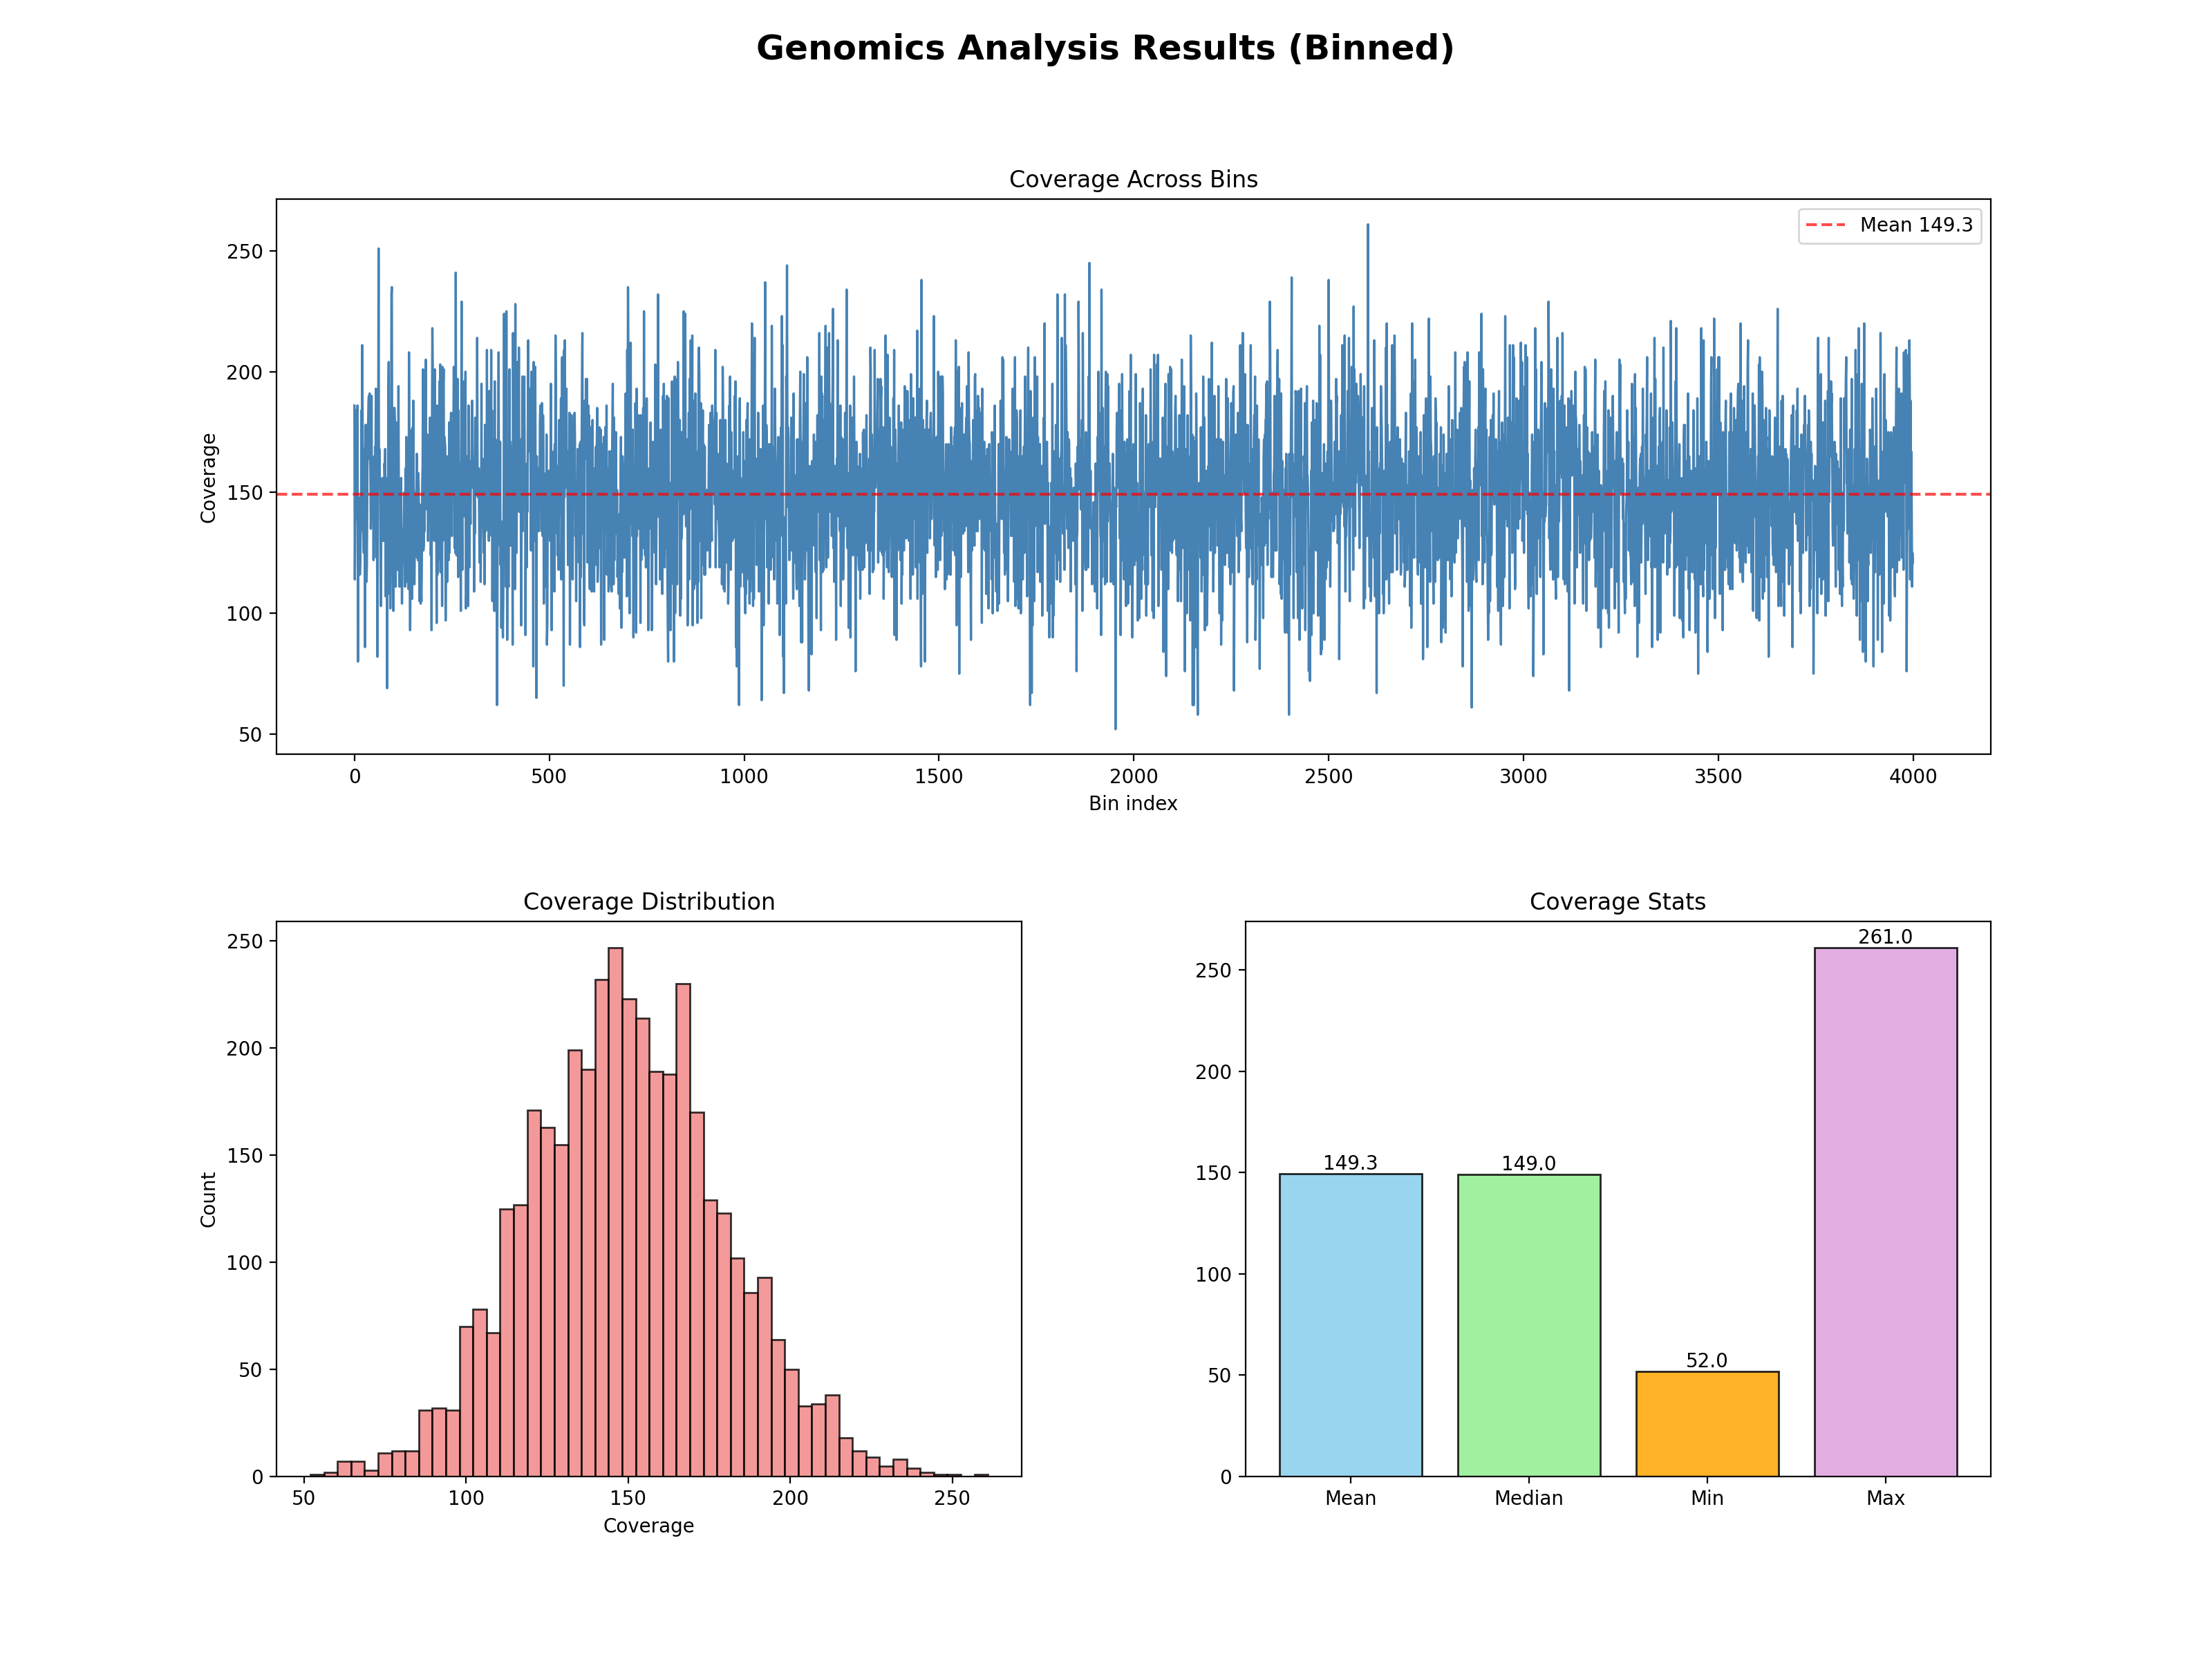

,metric,value,unit
0,total_reads,20000.00,reads
1,mapped_reads,19600.00,reads
2,mapping_rate,98.00,percent
3,mean_coverage,149.31,x
4,median_coverage,149.00,x
5,min_coverage,52.00,x
6,max_coverage,261.00,x
7,coverage_breadth,100.00,percent
8,variant_count,3.00,variants


In [20]:
from IPython.display import Markdown, Image, IFrame, display
import pandas as pd

out_dir = Path(run_art["output_dir"])
if not out_dir.is_absolute():
    out_dir = (REPO / out_dir).resolve()

print("Output dir:", out_dir)
for p in sorted(out_dir.iterdir()):
    print(" -", p.name)

rep = out_dir / "analysis_report.md"
if rep.exists(): display(Markdown(rep.read_text()))

png = out_dir / "genomics_analysis_plots.png"
if png.exists(): display(Image(filename=str(png)))

pdf = out_dir / "genomics_analysis_plots.pdf"
if pdf.exists(): display(IFrame(str(pdf), width=900, height=600))

tsv = out_dir / "analysis_summary.tsv"
if tsv.exists(): display(pd.read_csv(tsv, sep="\t"))

/Users/hamidbagheri/GitHub/a10i/mrp/.venv/bin/python -m mrp.cli.main run /Users/hamidbagheri/GitHub/a10i/mrp/examples/jobs/cloud_genomics.yaml --backend cloud_sandbox
Backend: cloud_sandbox
Run artifact: 23d4cf55b6bad32dbadeaf3e83afef704dc2ad9958fd886b389b5a506bdc0448
Output dir: /Users/hamidbagheri/GitHub/a10i/mrp/.mrp/outputs/cloud-genomics-001/20250809_212919


# Genomics Analysis Report

## Summary Metrics

- Total reads: 20,000
- Mapped reads: 19,600
- Mapping rate: 98.00%
- Mean coverage: 149.31x
- Median coverage: 149.00x
- Coverage breadth: 100.00%
- Variants found: 3

## Figures

See: genomics_analysis_plots.png and genomics_analysis_plots.pdf


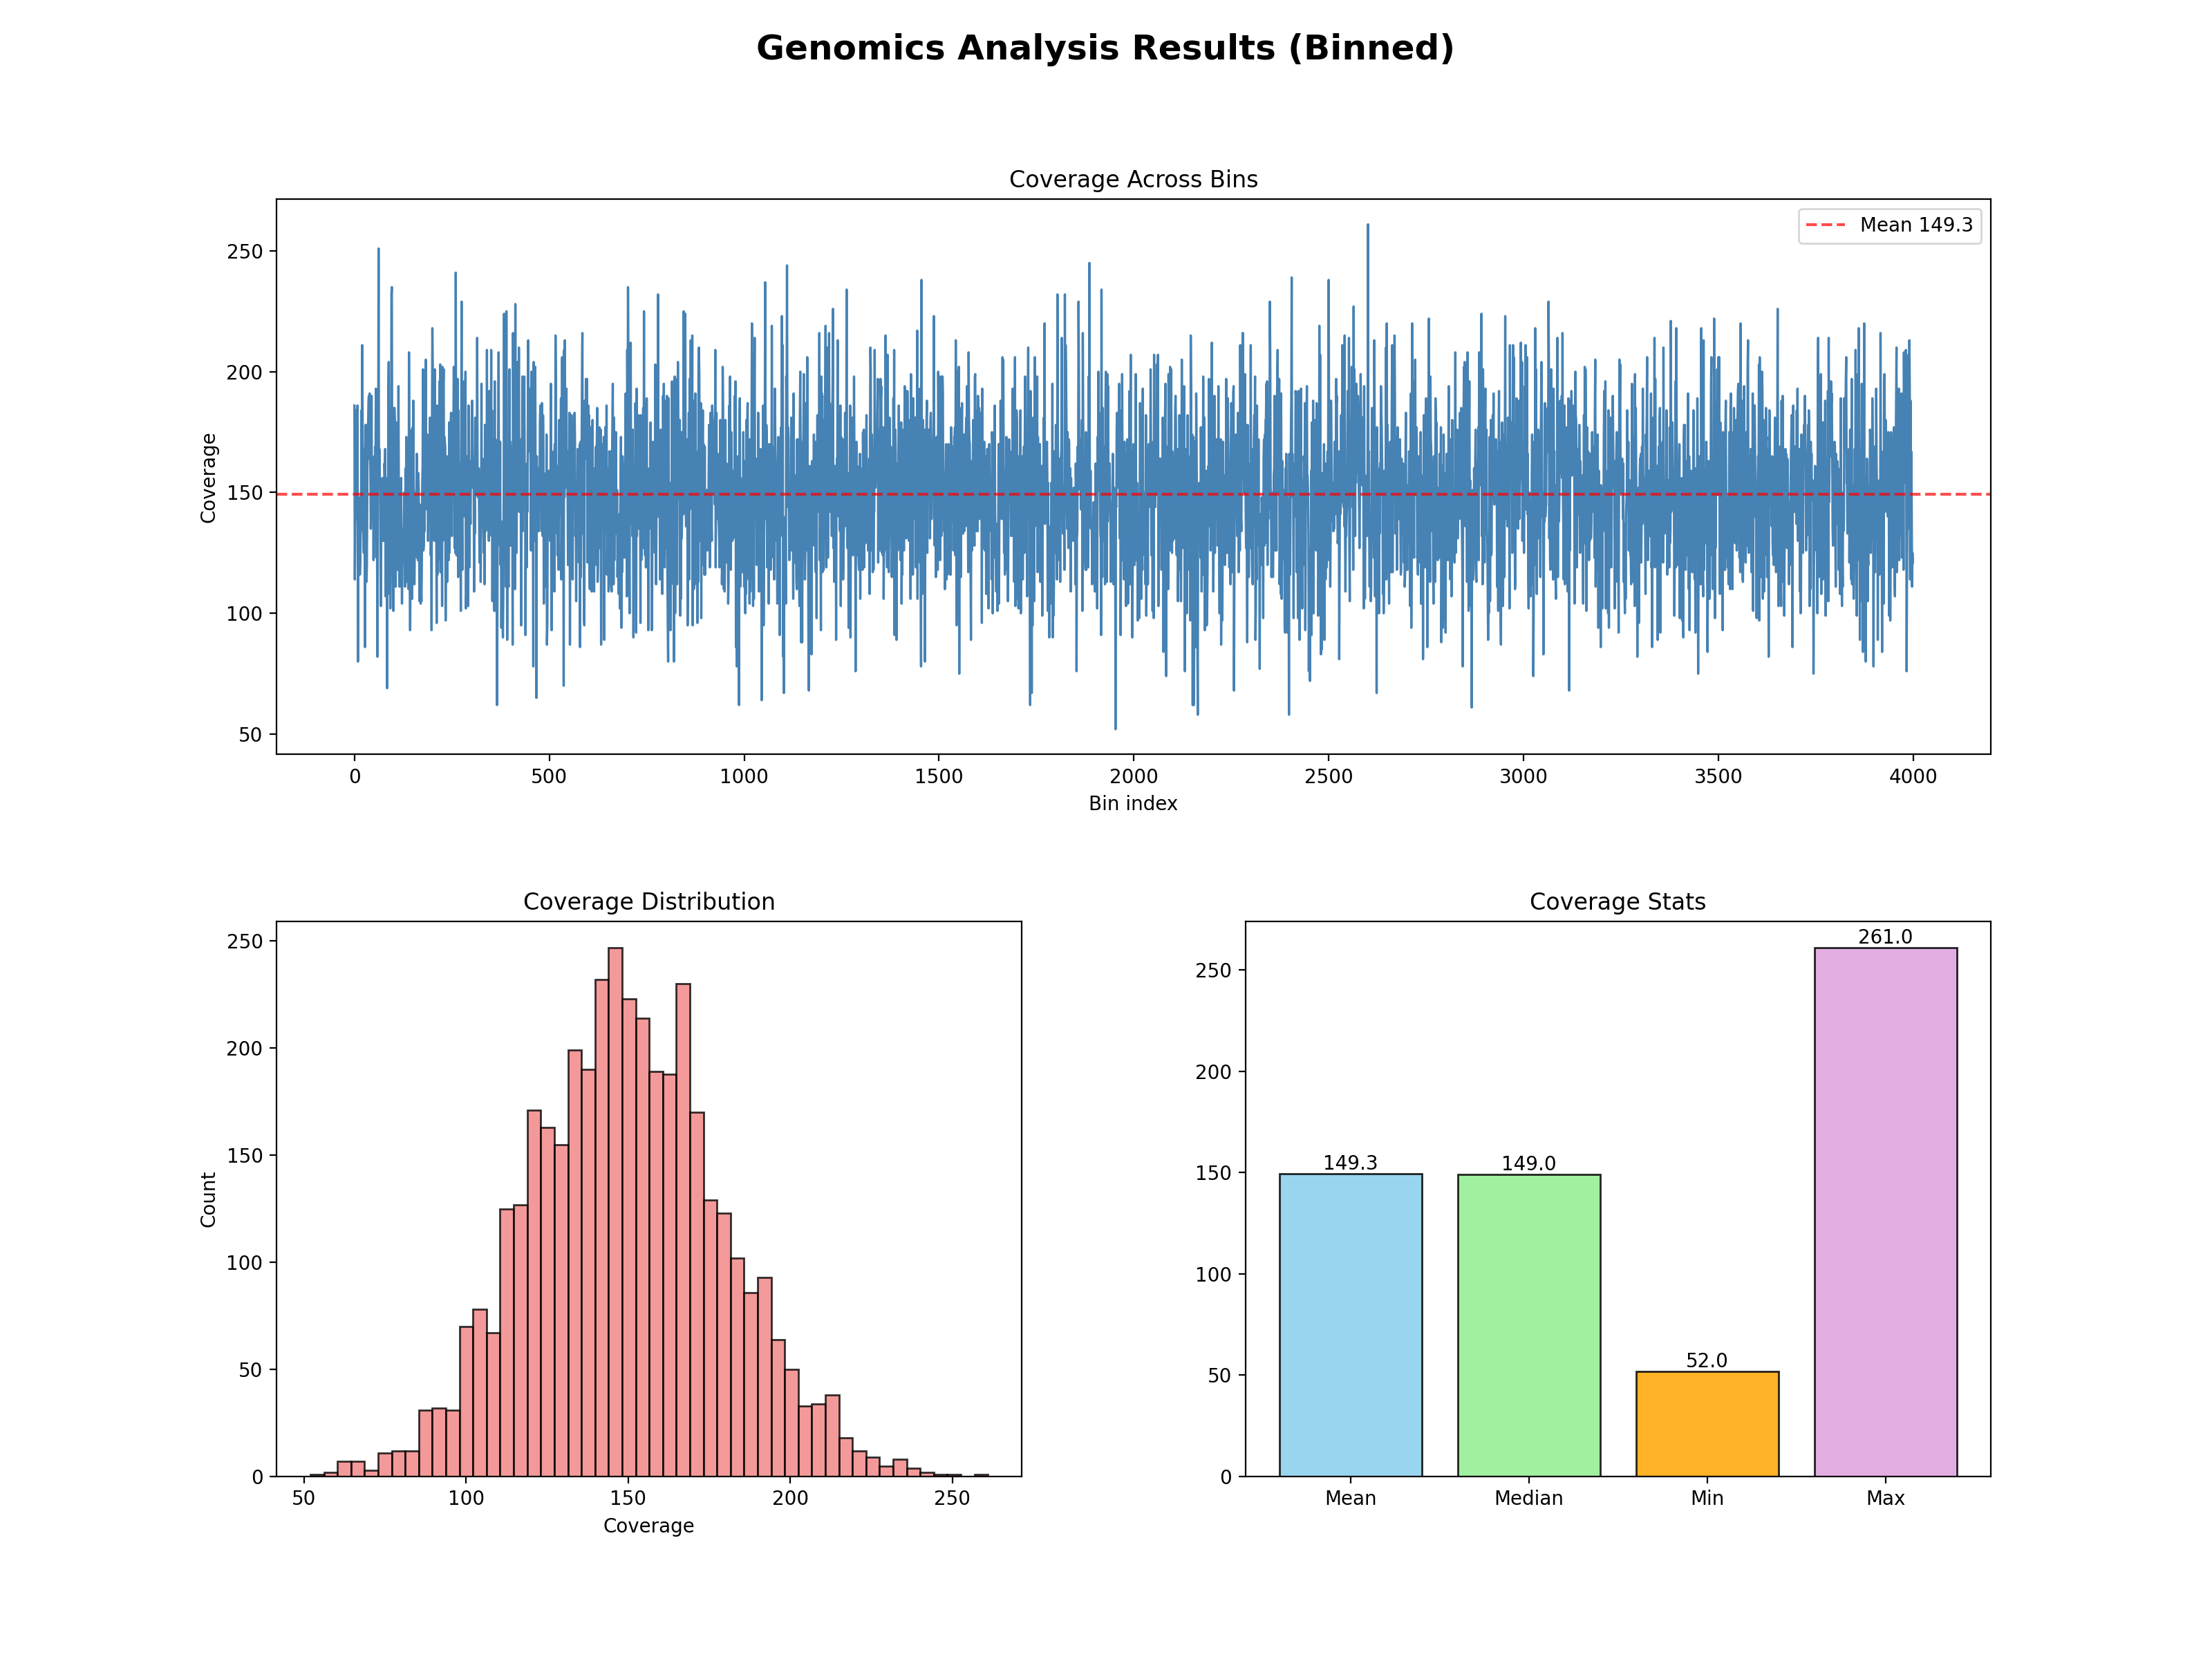

,metric,value,unit
0,total_reads,20000.00,reads
1,mapped_reads,19600.00,reads
2,mapping_rate,98.00,percent
3,mean_coverage,149.31,x
4,median_coverage,149.00,x
5,min_coverage,52.00,x
6,max_coverage,261.00,x
7,coverage_breadth,100.00,percent
8,variant_count,3.00,variants


In [ ]:
import os, sys, re, json, subprocess
from pathlib import Path
from IPython.display import Markdown, Image, IFrame, display
import pandas as pd

def repo_root(start: Path = Path.cwd()) -> Path:
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists():
            return p
    raise RuntimeError("Could not locate repo root")

REPO = repo_root()
JOB = REPO / "examples/jobs/cloud_genomics.yaml"   # change to another job if needed
BACKEND = "cloud_sandbox"                          # or "local"

# Ensure API key for cloud runs (skip if BACKEND=local)
if BACKEND == "cloud_sandbox" and not os.getenv("DAYTONA_API_KEY"):
    raise RuntimeError("Set DAYTONA_API_KEY in your env for cloud_sandbox.")

# Run job
cmd = [sys.executable, "-m", "mrp.cli.main", "run", str(JOB), "--backend", BACKEND]
print(" ".join(cmd))
res = subprocess.run(cmd, cwd=REPO, capture_output=True, text=True)
if res.returncode != 0:
    print("STDOUT:\n", res.stdout)
    print("STDERR:\n", res.stderr)
    raise RuntimeError(f"Run failed: {res.returncode}")

# Parse digest and load artifact
m = re.findall(r"\b[0-9a-f]{64}\b", res.stdout)
if not m:
    print("STDOUT:\n", res.stdout)
    raise RuntimeError("Could not find run digest in output")
run_digest = m[-1]
artifact = json.loads((REPO / ".mrp" / "artifacts" / f"{run_digest}.json").read_text())
out_dir = Path(artifact["output_dir"])
if not out_dir.is_absolute():
    out_dir = (REPO / out_dir).resolve()

print("Backend:", artifact.get("backend"))
print("Run artifact:", run_digest)
print("Output dir:", out_dir)

# Display results
rep = out_dir / "analysis_report.md"
if rep.exists():
    display(Markdown(rep.read_text()))

png = out_dir / "genomics_analysis_plots.png"
if png.exists():
    display(Image(filename=str(png)))

pdf = out_dir / "genomics_analysis_plots.pdf"
if pdf.exists():
    display(IFrame(str(pdf), width=900, height=600))

tsv = out_dir / "analysis_summary.tsv"
if tsv.exists():
    display(pd.read_csv(tsv, sep="\t"))